In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [ ]:
from google.colab import drive

In [ ]:
# Google Drive'ı bağladım
drive.mount('/content/drive')

# Dosya yolunu Drive'daki konumuna göre değiştirdim
file_path = '/content/drive/MyDrive/AAPL.csv'

# CSV dosyasını okudum
aapl = pd.read_csv(file_path, delimiter=',')
print(aapl.head())

Mounted at /content/drive
         Date  Price  Open  High   Low     Vol. Change %
0  12/12/1980   0.13  0.13  0.13  0.13  469.03M  -99.88%
1  12/15/1980   0.12  0.12  0.12  0.12  175.88M   -7.69%
2  12/16/1980   0.11  0.11  0.11  0.11  105.73M   -8.33%
3  12/17/1980   0.12  0.12  0.12  0.12   86.44M    9.09%
4  12/18/1980   0.12  0.12  0.12  0.12   73.45M    0.00%


In [ ]:
#dizini sıfırladım
aapl.reset_index(inplace=True)
print(aapl)

       index        Date   Price    Open    High     Low     Vol. Change %
0          0  12/12/1980    0.13    0.13    0.13    0.13  469.03M  -99.88%
1          1  12/15/1980    0.12    0.12    0.12    0.12  175.88M   -7.69%
2          2  12/16/1980    0.11    0.11    0.11    0.11  105.73M   -8.33%
3          3  12/17/1980    0.12    0.12    0.12    0.12   86.44M    9.09%
4          4  12/18/1980    0.12    0.12    0.12    0.12   73.45M    0.00%
...      ...         ...     ...     ...     ...     ...      ...      ...
10907  10907  03/21/2024  171.37  177.05  177.49  170.84  106.18M   -4.09%
10908  10908  03/22/2024  172.28  171.76  173.05  170.06   71.16M    0.53%
10909  10909  03/25/2024  170.85  170.37  171.94  169.46   54.21M   -0.83%
10910  10910  03/26/2024  169.71  170.01  171.41  169.65   57.22M   -0.67%
10911  10911  03/27/2024  173.31  170.30  173.58  170.14   59.11M    2.12%

[10912 rows x 8 columns]


In [ ]:
# ön işleme.
# Tarih sütununu datetime formatına çevirdim
aapl['Date'] = pd.to_datetime(aapl['Date'], format='%m/%d/%Y')


In [ ]:
def clean_volume(vol):
    if isinstance(vol, str):
        vol = vol.strip()
        if 'B' in vol:
            return float(vol.replace('B', '')) * 1_000_000_000
        elif 'M' in vol:
            return float(vol.replace('M', '')) * 1_000_000
        elif 'K' in vol:
            return float(vol.replace('K', '')) * 1_000
    return float(vol)

def clean_change(change):
    if isinstance(change, str):
        change = change.strip().replace('%', '')
        if change.endswith('.'):
            change = change[:-1]
        return float(change) if change else 0.0
    return float(change)

# Dönüşümleri uyguladım
aapl['Vol.'] = aapl['Vol.'].apply(clean_volume)
aapl['Change %'] = aapl['Change %'].apply(clean_change)

print(aapl[['Vol.', 'Change %']].head())

          Vol.  Change %
0  469030000.0    -99.88
1  175880000.0     -7.69
2  105730000.0     -8.33
3   86440000.0      9.09
4   73450000.0      0.00


In [ ]:
# Veri çerçevesinin sütun isimlerini ve ilk birkaç satırını yazdıedım
print("Sütun isimleri:", aapl.columns.tolist())
print("\nİlk 5 satır:")
print(aapl.head())

Sütun isimleri: ['index', 'Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

İlk 5 satır:
   index       Date  Price  Open  High   Low         Vol.  Change %
0      0 1980-12-12   0.13  0.13  0.13  0.13  469030000.0    -99.88
1      1 1980-12-15   0.12  0.12  0.12  0.12  175880000.0     -7.69
2      2 1980-12-16   0.11  0.11  0.11  0.11  105730000.0     -8.33
3      3 1980-12-17   0.12  0.12  0.12  0.12   86440000.0      9.09
4      4 1980-12-18   0.12  0.12  0.12  0.12   73450000.0      0.00


In [ ]:
print(aapl.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10912 entries, 0 to 10911
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     10912 non-null  int64         
 1   Date      10912 non-null  datetime64[ns]
 2   Price     10912 non-null  float64       
 3   Open      10912 non-null  float64       
 4   High      10912 non-null  float64       
 5   Low       10912 non-null  float64       
 6   Vol.      10912 non-null  float64       
 7   Change %  10912 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 682.1 KB
None


In [ ]:
print(aapl.describe())

              index                           Date         Price  \
count  10912.000000                          10912  10912.000000   
mean    5455.500000  2002-07-26 23:48:23.225806464     20.962334   
min        0.000000            1980-12-12 00:00:00      0.050000   
25%     2727.750000            1991-09-26 18:00:00      0.300000   
50%     5455.500000            2002-07-24 12:00:00      0.520000   
75%     8183.250000            2013-05-25 00:00:00     19.312500   
max    10911.000000            2024-03-27 00:00:00    198.110000   
std     3150.167403                            NaN     43.543804   

               Open          High           Low          Vol.      Change %  
count  10912.000000  10912.000000  10912.000000  1.091200e+04  10912.000000  
mean      20.948320     21.174676     20.730037  3.200629e+08      0.129273  
min        0.050000      0.050000      0.050000  1.390000e+06    -99.880000  
25%        0.300000      0.300000      0.290000  1.147425e+08     -0.830000

In [ ]:
# Sütun isimlerindeki boşlukları temizledim
aapl.columns = aapl.columns.str.strip()
print("Düzeltilmiş sütun isimleri:", aapl.columns.tolist())

Düzeltilmiş sütun isimleri: ['index', 'Date', 'Close', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'MA_7', 'MA_21', 'RSI', 'MACD', 'Signal_Line']


In [ ]:
# Olası fiyat sütunu isimlerini kontrol ettim
possible_price_columns = ['Price', 'price', 'PRICE', 'Close', 'close', 'CLOSE', 'Last', 'last']

for col in possible_price_columns:
    if col in aapl.columns:
        print(f"Bulunan fiyat sütunu: {col}")
        aapl['Price'] = aapl[col]
        break
else:
    print("Hiçbir fiyat sütunu bulunamadı. Mevcut sütunlar:", aapl.columns.tolist())

Bulunan fiyat sütunu: Close


In [ ]:
def add_technical_indicators(df):
    # Fiyat sütununu bulma
    price_col = None
    possible_cols = ['Price', 'price', 'Close', 'close', 'Last', 'last']

    for col in possible_cols:
        if col in df.columns:
            price_col = col
            break

    if price_col is None:
        raise ValueError("Fiyat verisi içeren sütun bulunamadı")

    # Hareketli Ortalamaları bulma
    df['MA_7'] = df[price_col].rolling(window=7).mean()
    df['MA_21'] = df[price_col].rolling(window=21).mean()

    # RSI
    delta = df[price_col].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df.dropna()

# Teknik göstergeleri ekledim
try:
    aapl = add_technical_indicators(aapl)
    print("Teknik göstergeler başarıyla eklendi:")
    print(aapl.tail())
except Exception as e:
    print("Hata:", e)

Teknik göstergeler başarıyla eklendi:
       index       Date   Close    Open    High     Low         Vol.  \
10907  10907 2024-03-21  171.37  177.05  177.49  170.84  106180000.0   
10908  10908 2024-03-22  172.28  171.76  173.05  170.06   71160000.0   
10909  10909 2024-03-25  170.85  170.37  171.94  169.46   54210000.0   
10910  10910 2024-03-26  169.71  170.01  171.41  169.65   57220000.0   
10911  10911 2024-03-27  173.31  170.30  173.58  170.14   59110000.0   

       Change %        MA_7       MA_21        RSI      MACD  Signal_Line  \
10907     -4.09  173.798571  175.673810  37.281375 -2.604508    -3.213056   
10908      0.53  173.962857  175.098095  45.127851 -2.577754    -3.085996   
10909     -0.83  173.655714  174.542381  51.437574 -2.641491    -2.997095   
10910     -0.67  173.240000  173.997143  51.155503 -2.752265    -2.948129   
10911      2.12  173.181429  173.553333  57.428473 -2.520510    -2.862605   

        Price  
10907  171.37  
10908  172.28  
10909  170.85  
10

Mevcut sütunlar: ['index', 'Date', 'Close', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'MA_7', 'MA_21', 'RSI', 'MACD', 'Signal_Line', 'Price']
Kullanılacak fiyat sütunu: 'Close'

Teknik Göstergelerle Son 5 Kayıt:
            Date   Close        MA_7       MA_21        RSI
10907 2024-03-21  171.37  173.798571  175.673810  37.281375
10908 2024-03-22  172.28  173.962857  175.098095  45.127851
10909 2024-03-25  170.85  173.655714  174.542381  51.437574
10910 2024-03-26  169.71  173.240000  173.997143  51.155503
10911 2024-03-27  173.31  173.181429  173.553333  57.428473


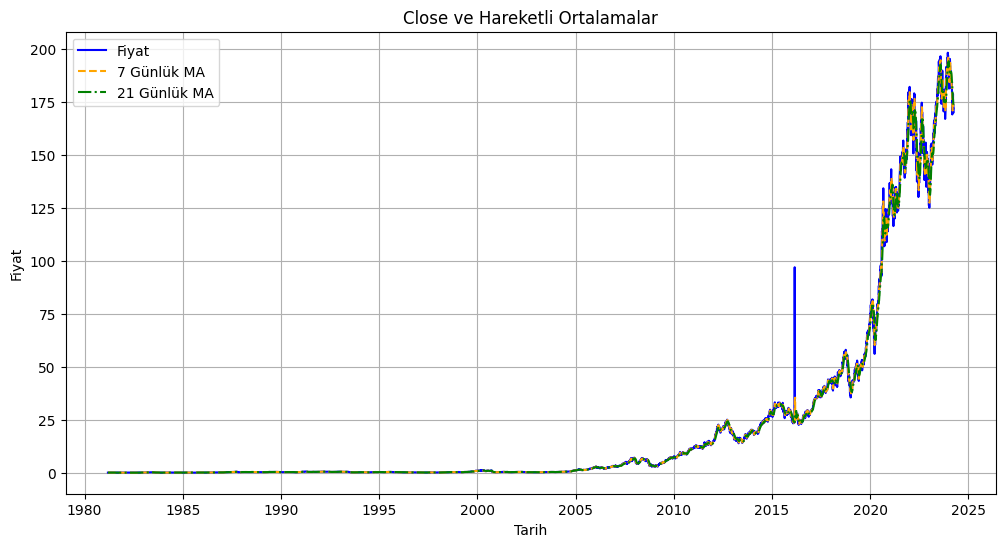

In [ ]:
# Önce sütun isimlerini temizledim ve kontrol ediyorum
aapl.columns = aapl.columns.str.strip()
print("Mevcut sütunlar:", aapl.columns.tolist())

price_column = None
for col in aapl.columns:
    if col.lower() in ['price', 'close', 'last']:
        price_column = col
        break

if price_column is None:
    raise ValueError("Fiyat verisi içeren sütun bulunamadı")

print(f"Kullanılacak fiyat sütunu: '{price_column}'")

def add_technical_indicators(df, price_col):
    df = df.copy()

    # Hareketli Ortalamaları yazdırdım
    df['MA_7'] = df[price_col].rolling(window=7).mean()
    df['MA_21'] = df[price_col].rolling(window=21).mean()

    # RSI
    delta = df[price_col].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df.dropna()

# Teknik göstergeleri ekledim
aapl = add_technical_indicators(aapl, price_column)

# SONUÇLARI GÖRÜNTÜLEDİM
display_columns = ['Date', price_column, 'MA_7', 'MA_21', 'RSI']
print("\nTeknik Göstergelerle Son 5 Kayıt:")
print(aapl[display_columns].tail())

# Görselleştirdim
plt.figure(figsize=(12,6))
plt.plot(aapl['Date'], aapl[price_column], label='Fiyat', color='blue')
plt.plot(aapl['Date'], aapl['MA_7'], label='7 Günlük MA', color='orange', linestyle='--')
plt.plot(aapl['Date'], aapl['MA_21'], label='21 Günlük MA', color='green', linestyle='-.')
plt.title(f"{price_column} ve Hareketli Ortalamalar")
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# secilen_veriler DataFramedeki Price sütununun ortalamasını alıyoeum
ortalama_price = secilen_veriler['Price'].mean()
ortalama_open = secilen_veriler['Open'].mean()
ortalama_high = secilen_veriler['High'].mean()
ortalama_low = secilen_veriler['Low'].mean()
#ortalama_vol = secilen_veriler['Vol.'].mean()
#ortalama_change = secilen_veriler['Change %'].mean()

In [ ]:
# Ortalama fiyatı yazdırdım
print("Ortalama Price:", ortalama_price)
print("Ortalama open:", ortalama_open)
print("Ortalama high:", ortalama_high)
print("Ortalama low:", ortalama_low)
#print("Ortalama Price:", ortalama_vol)
#print("Ortalama Price:", ortalama_chang)"""
"""vol. ve change verilerini int olmadığı için onlarla işlem yapamadım. manuel olarak doldurcağım."""

Ortalama Price: 0.8156972111553785
Ortalama open: 0.8174103585657371
Ortalama high: 0.8435458167330678
Ortalama low: 0.7922709163346614


'vol. ve change verilerini int olmadığı için onlarla işlem yapamadım. manuel olarak doldurcağım.'

In [ ]:
#ön işlemeyi bitirdim kontrol ediyorum.
eksik_degerler = aapl.isnull().sum()
print("Eksik Değerler:\n", eksik_degerler)

Eksik Değerler:
 index          0
Date           0
Close          0
Open           0
High           0
Low            0
Vol.           0
Change %       0
MA_7           0
MA_21          0
RSI            0
MACD           0
Signal_Line    0
Price          0
dtype: int64


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# Veriyi hazırlama fonksiyonum
def prepare_data(df, look_back=60):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(df)

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i, 0])  # Close price'ı tahmin ediyoruz

    return np.array(X), np.array(y), scaler

# Tüm özellikleri seçtim
features = ['Open', 'High', 'Low', 'Close', 'Vol.', 'Change %', 'MA_7', 'MA_21', 'RSI', 'MACD', 'Signal_Line']
X, y, scaler = prepare_data(aapl[features])

# Eğitim ve test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM modeli
def build_lstm_model(input_shape):
    model = Sequential()

    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mse')
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

# Callback'ler
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Model eğitimi
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021

268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0021 - val_loss: 0.0296
Epoch 2/20
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2064e-05

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 6.2032e-05 - val_loss: 0.0249
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 4.9924e-05 - val_loss: 0.0363
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 4.9796e-05 - val_loss: 0.0307
Epoch 5/20
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4952e-05

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.4963e-05 - val_loss: 0.0200
Epoch 6/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 4.6102e-05 - val_loss: 0.0206
Epoch 7/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 4.2856e-05 - val_loss: 0.0212
Epoch 8/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 4.2336e-05 - val_loss: 0.0262
Epoch 9/20
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.4737e-05

268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 4.4759e-05 - val_loss: 0.0155
Epoch 10/20
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0676e-05

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 5.0614e-05 - val_loss: 0.0120
Epoch 11/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 3.4566e-05 - val_loss: 0.0140
Epoch 12/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.7514e-05 - val_loss: 0.0261
Epoch 13/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 3.3652e-05 - val_loss: 0.0174
Epoch 14/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 3.4704e-05 - val_loss: 0.0201
Epoch 15/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.5104e-05 - val_loss: 0.0220
Epoch 16/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.6085e-05 - val_loss: 0.0203
Epoch 17/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 3.4263e-05 - val_loss: 0.0244
Epoch 18/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.6802e-05 - val_loss: 0.0149
Epoch 19/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 4.3697e-05 - val_loss: 0.0282
Epoch 20/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4247e-05 - val_loss: 0.0221


268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


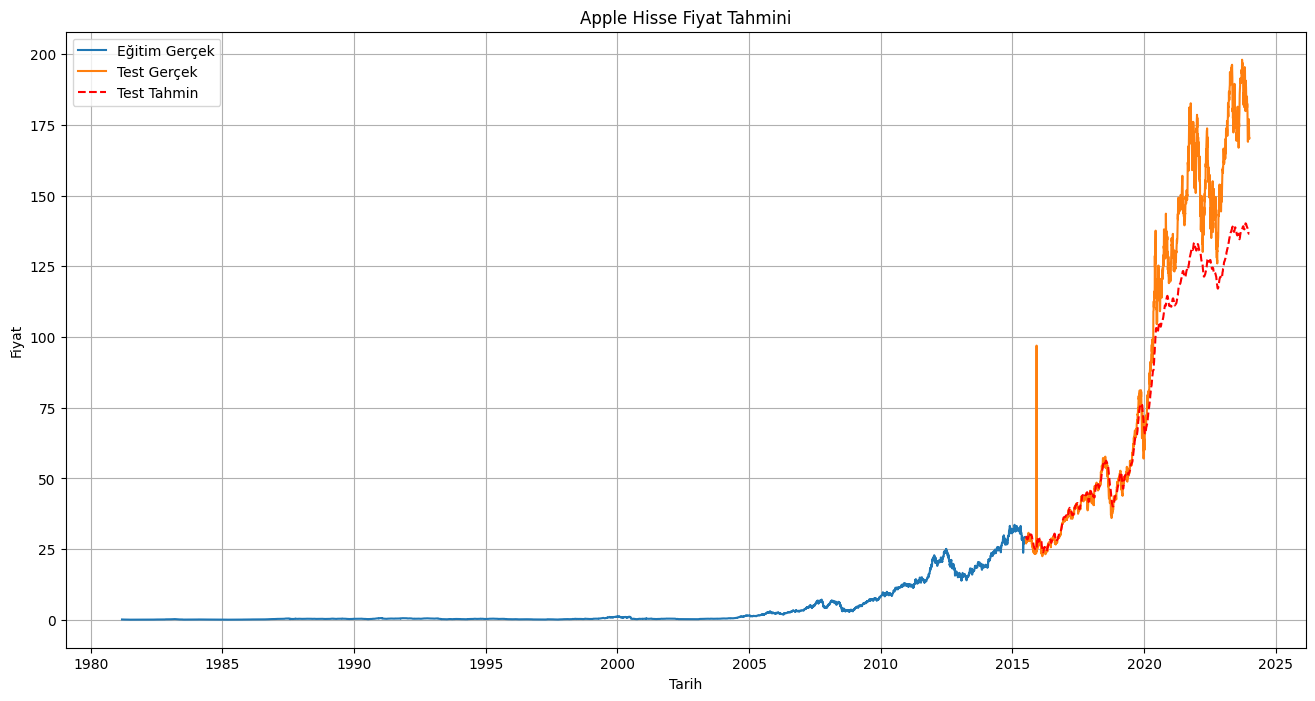


Model Performans Metrikleri:
Test MAE: 14.07
Test RMSE: 21.68
Test R² Skoru: 0.86


In [ ]:
# Tahminleri aldim
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirmeyi geri aldım
def inverse_scale(scaler, data, n_features):
    """Scaler dönüşümü için güvenli fonksiyon"""
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    if n_features == 1:
        return scaler.inverse_transform(data).flatten()
    else:
        dummy = np.zeros((len(data), n_features-1))
        return scaler.inverse_transform(np.hstack((data, dummy)))[:, 0]

# Özellik sayısı
n_features = X_train.shape[2] if len(X_train.shape) > 2 else 1

# Dönüşümleri uyguladım
train_predict = inverse_scale(scaler, train_predict, n_features)
y_train_actual = inverse_scale(scaler, y_train, n_features)
test_predict = inverse_scale(scaler, test_predict, n_features)
y_test_actual = inverse_scale(scaler, y_test, n_features)

# Tarih bilgisini ayarladım
def get_dates(df, y_actual, offset=0):
    """Tarih aralığını doğru şekilde al"""
    if len(y_actual) + offset > len(df):
        return df['Date'].iloc[-len(y_actual):]
    return df['Date'].iloc[offset:offset+len(y_actual)]

# Görselleştirdim
plt.figure(figsize=(16,8))
plt.plot(get_dates(aapl, y_train_actual), y_train_actual, label='Eğitim Gerçek')
plt.plot(get_dates(aapl, y_test_actual, len(y_train_actual)), y_test_actual, label='Test Gerçek')
plt.plot(get_dates(aapl, test_predict, len(y_train_actual)), test_predict, 'r--', label='Test Tahmin')
plt.title('Apple Hisse Fiyat Tahmini')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.grid(True)
plt.show()

# Hata metrikleri
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("\nModel Performans Metrikleri:")
print(f"Test MAE: {mean_absolute_error(y_test_actual, test_predict):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_actual, test_predict)):.2f}")
print(f"Test R² Skoru: {r2_score(y_test_actual, test_predict):.2f}")